In [233]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt

## Quantum system

In [234]:
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.106.120402

# order: |1>, |2>, |3>
H0 = Matrix(Diagonal([1, 1.1, 1.2]))


# Control Hamiltonian
V = [
    0 0 1;
    0 0 1;
    1 1 0
]


3×3 Matrix{Int64}:
 0  0  1
 0  0  1
 1  1  0

## Utilities for working with Polynomials

In [235]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [236]:
@polyvar x[1:2]
@polyvar t[1:3]

# final time
const T = 0.5

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T);

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
);

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Chebyshve polynomial approximation for $\exp_p(\Omega^{(n)})$ with $n=3$ and $p=7$

In [237]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 1) * Tₙ₋₁ + 2 * besselj(1, 1) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 1) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

Ω = convert(typeof(A₁), Ω)

expΩ = exp_chebyshev(Ω, 7);

## Utilities 

In [238]:
function get_unitary(x::AbstractArray)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

function magnus_convergence_test(x::AbstractArray)
    val = quadgk(t -> opnorm(A(t, x)), 0, T)[1] / π
    if val > 1
        println("Magnus expansion failed convergence test")
    end
    val
end

magnus_convergence_test (generic function with 1 method)

### Define the target observable $O$ whose expectation value is to be maximized 

In [239]:
λ = [0.1, 1, 0]

@assert size(λ)[1] == size(H0)[1]
@assert λ[2] > λ[1] > λ[3]

O = Diagonal(λ)

3×3 Diagonal{Float64, Vector{Float64}}:
 0.1   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   0.0

In [240]:
function expectation_O(x::AbstractArray)
    
    # |1> is the intial state
    Ψ = get_unitary(x) * [1; 0; 0]
    
    real(Ψ' * O * Ψ)
end

expectation_O (generic function with 1 method)

In [241]:
ψ = expΩ * [1; 0; 0]
obj = -real_poly(ψ' * O * ψ);

In [242]:
# Get the global minimum via TSSOS library
opt,sol,data = tssos_first(
    [obj; [ξ + 2 for ξ in x]; [-ξ + 2 for ξ in x]], 
    variables(obj), maxdegree(obj) ÷ 2, numeq=0; QUIET = true, solution = true,
)
    
previous_sol = sol
previous_opt = opt
    
while ~isnothing(sol)
    previous_sol = sol
    previous_opt = opt
            
    opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
end
    
tssos_glob_obj_min = previous_opt
glob_min_x = previous_sol

***************************TSSOS***************************
TSSOS is launching...
termination status: SLOW_PROGRESS
solution status: UNKNOWN_RESULT_STATUS
optimum = -0.21138634149829647
Found a local optimal solution giving an upper bound: -0.377074213289626 and a relative optimality gap: 0.16568787179132952.


2-element Vector{Float64}:
 2.000000003731255
 1.9999999848819774

In [243]:
magnus_convergence_test(glob_min_x)

0.7419299203384292

In [124]:
expectation_O(glob_min_x)

0.09999999990993125

In [98]:
grad = differentiate.(obj, x);

In [99]:
map(z -> z(glob_min_x), grad)

2-element Vector{Float64}:
  7.055033353379222e-11
 -8.325783971688282e-10

In [100]:
map(z -> z([0, 0]), grad)

2-element Vector{Float64}:
 0.0
 0.0

In [101]:
map(z -> z(rand(2)), grad)

2-element Vector{Float64}:
 -0.021037369599371886
  0.003142394631644175

In [102]:
using Plots
using LaTeXStrings

In [218]:
x_range = Vector(-2:0.1:2)

landscape_O = [expectation_O([x1, x2]) for x1 = x_range, x2 = x_range];

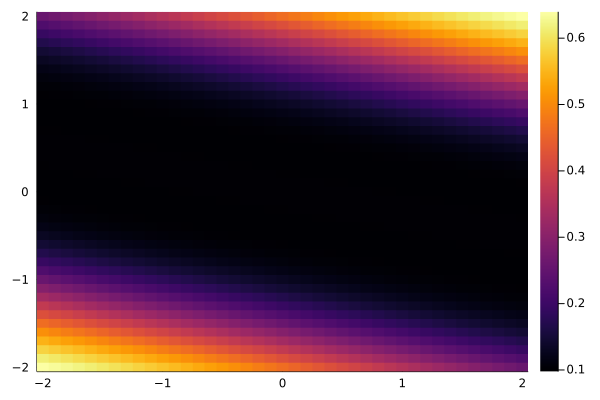

In [219]:
heatmap(x_range, x_range, landscape_O)

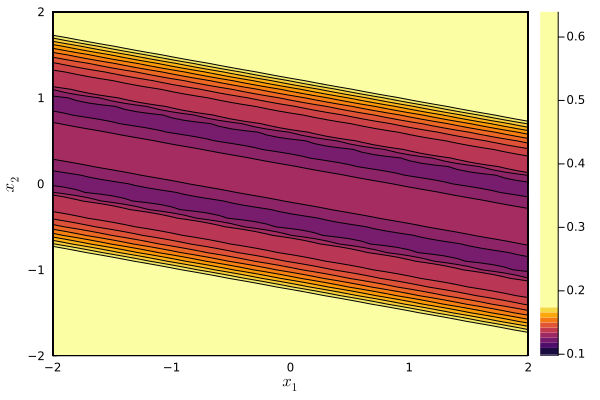

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots /home/denys/.julia/packages/Plots/E2187/src/backends/gr.jl:548


In [220]:
contourf(
    x_range, x_range, landscape_O, 
    levels=[range(minimum(lanscape), 0.1, 10); range(0.11, maximum(lanscape), 10)]
)
xlabel!(L"x_1")
ylabel!(L"x_2")

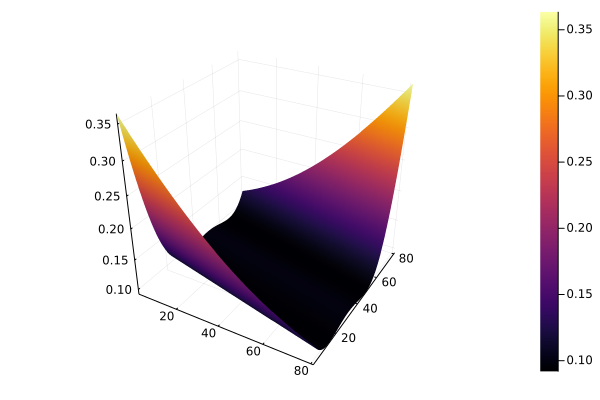

In [140]:
surface(landscape_O)

In [191]:
landscape_obj = [-obj([x1, x2]) for x1 = x_range, x2 = x_range];

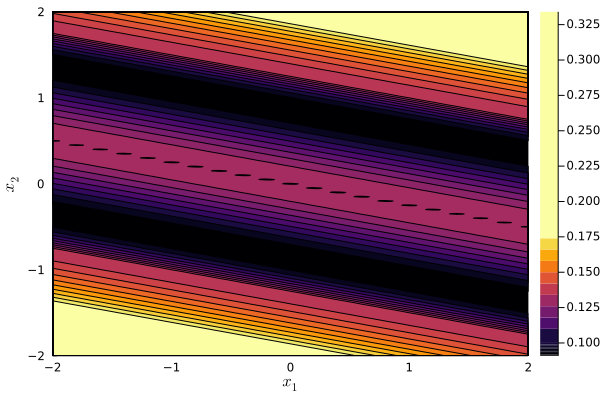

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots /home/denys/.julia/packages/Plots/E2187/src/backends/gr.jl:548


In [192]:
contourf(
    x_range, x_range, landscape_obj, 
    levels=[range(minimum(lanscape), 0.1, 10); range(0.11, maximum(lanscape), 10)]
)
xlabel!(L"x_1")
ylabel!(L"x_2")